Epoch 0: Total Loss: 2.7650e+03, Loss f: 2.4265e-07, Loss BC0: 1.3732e-03, Loss BC1: 1.3825e+03, Loss BC2: 1.3825e+03
lambda_f: 1.0, lambda_BC0: 1.0, lambda_BC1: 1.0512710809707642, lambda_BC2: 1.0512710809707642
Epoch 100: Total Loss: 2.7674e+02, Loss f: 4.8767e-03, Loss BC0: 1.1758e-02, Loss BC1: 2.2887e+01, Loss BC2: 2.2888e+01
lambda_f: 1.0000078678131104, lambda_BC0: 1.00003981590271, lambda_BC1: 6.095496654510498, lambda_BC2: 6.095541477203369
Epoch 200: Total Loss: 4.3911e+02, Loss f: 4.9001e-03, Loss BC0: 5.5385e-03, Loss BC1: 1.9850e+01, Loss BC2: 1.9850e+01
lambda_f: 1.0001511573791504, lambda_BC0: 1.0002450942993164, lambda_BC1: 11.110337257385254, lambda_BC2: 11.110433578491211
Epoch 300: Total Loss: 6.0906e+02, Loss f: 4.8647e-03, Loss BC0: 2.9308e-04, Loss BC1: 1.8951e+01, Loss BC2: 1.8951e+01
lambda_f: 1.0002442598342896, lambda_BC0: 1.0002994537353516, lambda_BC1: 16.119510650634766, lambda_BC2: 16.119741439819336
Epoch 400: Total Loss: 7.4293e+02, Loss f: 4.9409e-03, L

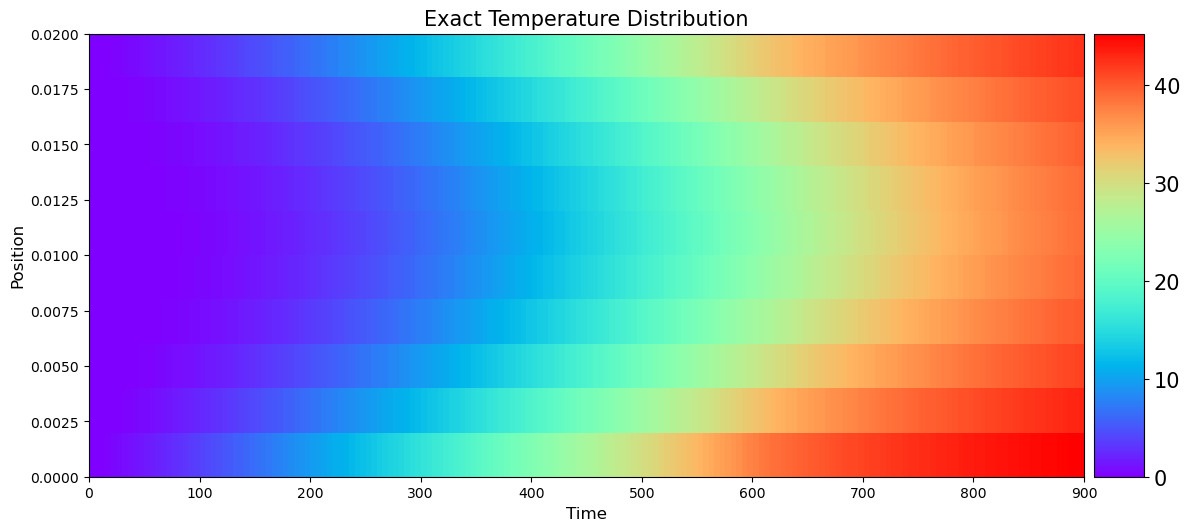

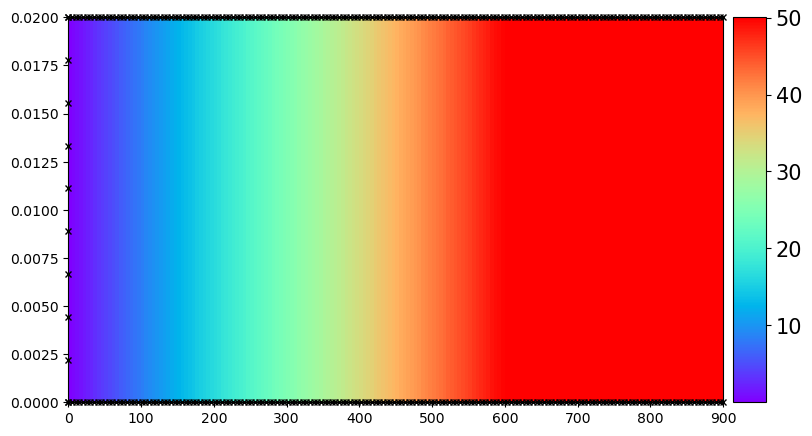

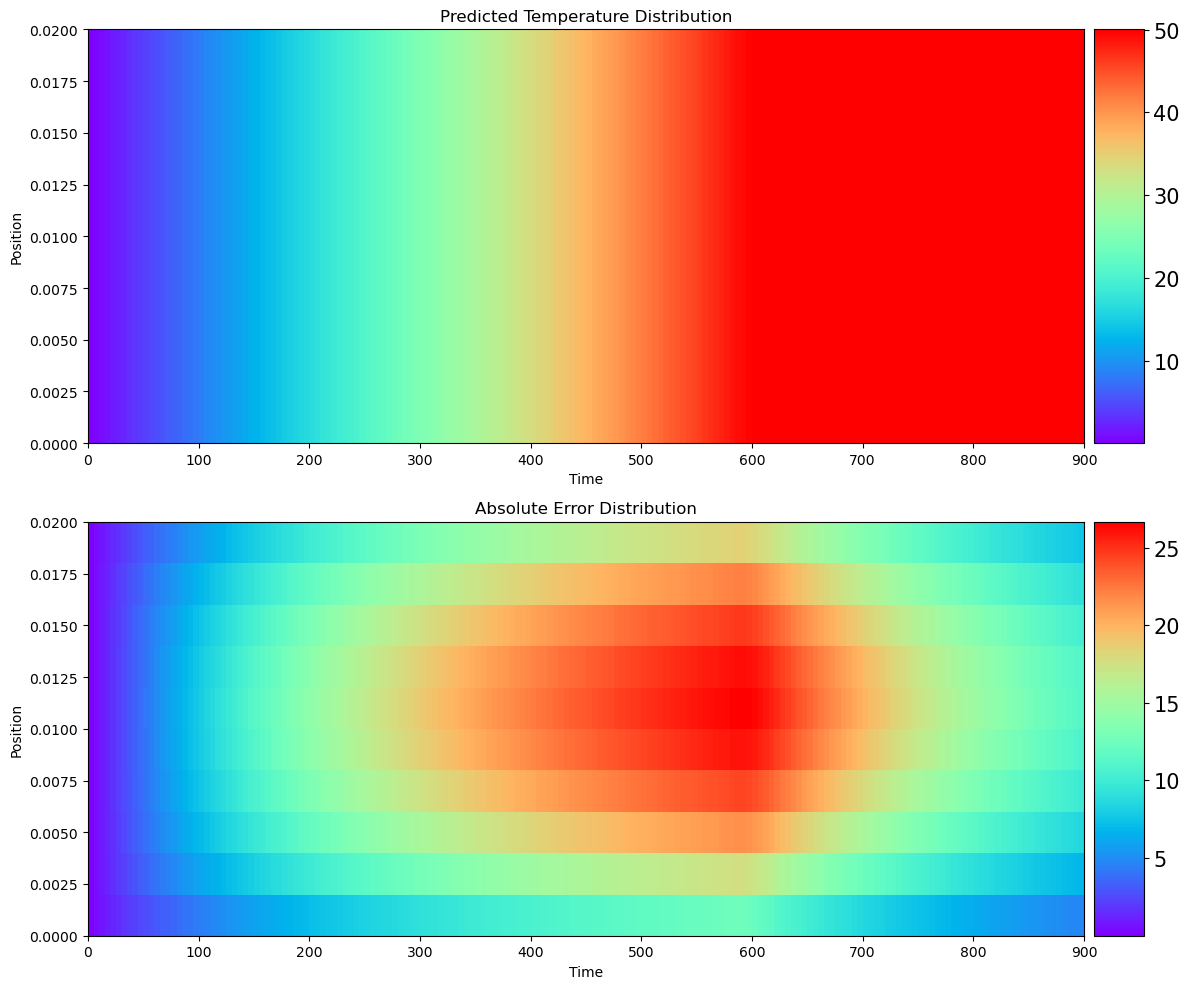

In [15]:
# スケーリングしないバージョン
import sys
sys.path.insert(0, './Utilities/')

import torch
from collections import OrderedDict
from pyDOE import lhs
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
from mpl_toolkits.axes_grid1 import make_axes_locatable
import time

np.random.seed(1234)

if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

K = 0.47
rho = 1573
cp = 967
alpha = K / (rho * cp)
h1 = 100
h2 = 50
lambda_f, lambda_BC0, lambda_BC1, lambda_BC2 = 1.0, 1.0, 1.0, 1.0
N_u = 200
N_f = 10000
layers = [2, 50, 50, 50, 50, 50, 50, 50, 50, 1]

x = np.linspace(0, 0.02, 10)[:, None]
t = np.linspace(0, 900, 180)[:, None]

# メッシュグリッドの作成
X, T = np.meshgrid(x, t)

dx = x[1] - x[0]
dt = t[1] - t[0]

Nx = len(x)
Nt = len(t)
u = np.zeros((Nt, Nx))

# 正しい解の計算
for n in range(0, Nt - 1):
    if t[n] <= 600:
        T_ext1 = T_ext2 = 0 + (50 - 0) * t[n] / 600
    else:
        T_ext1 = T_ext2 = 50
    for i in range(1, Nx - 1):
        u[n + 1, i] = u[n, i] + alpha * dt * (u[n, i - 1] - 2 * u[n, i] + u[n, i + 1]) / dx**2

    u[n + 1, 0] = (4 * u[n + 1, 1] - u[n + 1, 2] + 2 * dx * h1 / K * T_ext1) / (3 + 2 * dx * h1 / K)
    u[n + 1, -1] = (4 * u[n + 1, -2] - u[n + 1, -3] + 2 * dx * h2 / K * T_ext2) / (3 + 2 * dx * h2 / K)

# X_star, u_starの作成
X_star = np.hstack((X.flatten()[:, None], T.flatten()[:, None]))
u_star = u.flatten()[:, None]

# スケーリング関数
def scale_x(x):
    return 2.0 * (x - lb[0]) / (ub[0] - lb[0]) - 1.0
def scale_t(t):
    return (t - lb[1]) / (ub[1] - lb[1])
def unscale_x(x):
    return 0.5 * (x + 1.0) * (ub[0] - lb[0]) + lb[0]
def unscale_t(t):
    return t * (ub[1] - lb[1]) + lb[1]

# スケーリングの準備
lb = X_star.min(0) # lb: [0. 0.]
ub = X_star.max(0) # ub: [2.0e-02 9.0+02]

# xのスケーリング   
x_scaled = scale_x(x)
# tのスケーリング
t_scaled = scale_t(t)

# X, Tのスケーリング
X_scaled, T_scaled = np.meshgrid(x_scaled, t_scaled)

# X_starをスケーリング
X_star_scaled = np.copy(X_star)
X_star_scaled[:, 0] = scale_x(X_star[:, 0])
X_star_scaled[:, 1] = scale_t(X_star[:, 1])

# パラメータのスケーリング
K_scaled = K * (ub[0] - lb[0]) / 2
rho_scaled = rho * ((ub[0] - lb[0]) / 2) ** 3
cp_scaled = cp / (ub[1] - lb[1])
alpha_scaled = K_scaled / (rho_scaled * cp_scaled)

h1_scaled = h1 * ((ub[0] - lb[0]) / 2) ** 2
h2_scaled = h2 * ((ub[0] - lb[0]) / 2) ** 2


# 初期条件と境界条件のデータを準備
xx1 = np.hstack((X[0:1, :].T, T[0:1, :].T))
uu1 = u[0:1, :].T
xx2 = np.hstack((X[:, 0:1], T[:, 0:1]))
uu2 = u[:, 0:1]
xx3 = np.hstack((X[:, -1:], T[:, -1:]))
uu3 = u[:, -1:]

# 初期・境界条件のデータを結合
# X_u_train = np.vstack([xx1, xx2, xx3])
X_BC0_train = np.vstack([xx1]) #(10, 2)初期条件
X_BC1_train = np.vstack([xx2]) #(180, 2)x=0の境界条件
X_BC2_train = np.vstack([xx3]) #(180, 2)x=0.02の境界条件

# ランダムサンプリング
# 境界条件周辺（x=0と0.02付近）とそれ以外の領域からのサンプリング
N_f_boundary = N_f // 2  # 境界付近のサンプル数
N_f_interior = N_f - N_f_boundary  # 内部領域のサンプル数

# 境界付近のサンプリング
boundary_width = 0.001  # 境界とみなす幅
# low: サンプリングする範囲の下限。ここでは2次元配列 [0, lb[1]] を指定しています。
# x座標の下限は0（左端）
# t座標の下限はlb[1]
# high: サンプリングする範囲の上限。ここでは [boundary_width, ub[1]] を指定しています。
# x座標の上限はboundary_width（境界付近の幅）
# t座標の上限はub[1]（時間の最大値）
X_f_boundary_left = np.random.uniform(low=[lb[0], lb[1]], high=[boundary_width, ub[1]], size=(N_f_boundary // 2, 2))
X_f_boundary_right = np.random.uniform(low=[ub[0] - boundary_width, lb[1]], high=[ub[0], ub[1]], size=(N_f_boundary - N_f_boundary // 2, 2))

# 内部領域のサンプリング
X_f_interior = np.random.uniform(low=[boundary_width, lb[1]], high=[ub[0] - boundary_width, ub[1]], size=(N_f_interior, 2))

# すべてのサンプルを結合
X_f_train = np.vstack((X_f_boundary_left, X_f_boundary_right, X_f_interior))

#ランダムサンプリングのデータと初期・境界条件のデータを結合
X_f_train = np.vstack((X_f_train, X_BC0_train, X_BC1_train, X_BC2_train))
# print('X_f_train:', X_f_train.shape)→(17300, 2)
# print('X_f_train.tail:', X_f_train[-1])

# 初期・境界条件での温度分布
# u_train = np.vstack([uu1, uu2, uu3])
# print('u_train:', u_train.shape)→(500,1)

# TODO：あとで修正する
# X_u_trainの行数からN_u個のランダムなインデックスを生成。
# idx = np.random.choice(X_u_train.shape[0], N_u, replace=False)
# 初期・境界条件のデータをN_u個に絞る
# X_u_train = X_u_train[idx, :]
# u_train = u_train[idx, :]

# まとめ
# X_BC0_train: 初期条件の位置・時間データ
# X_BC1_train: x=0の境界条件の位置・時間データ
# X_BC2_train: x=0.02の境界条件の位置・時間データ
# X_f_train: ランダムサンプリングの位置・時間データ

# 初期・境界条件・ランダムサンプリングのデータをスケーリング
X_f_train_scaled = np.copy(X_f_train)
X_f_train_scaled[:, 0] = scale_x(X_f_train[:, 0])
X_f_train_scaled[:, 1] = scale_t(X_f_train[:, 1])

X_BC0_train_scaled = np.copy(X_BC0_train)
X_BC0_train_scaled[:, 0] = scale_x(X_BC0_train[:, 0])
X_BC0_train_scaled[:, 1] = scale_t(X_BC0_train[:, 1])

X_BC1_train_scaled = np.copy(X_BC1_train)
X_BC1_train_scaled[:, 0] = scale_x(X_BC1_train[:, 0])
X_BC1_train_scaled[:, 1] = scale_t(X_BC1_train[:, 1])

X_BC2_train_scaled = np.copy(X_BC2_train)
X_BC2_train_scaled[:, 0] = scale_x(X_BC2_train[:, 0])
X_BC2_train_scaled[:, 1] = scale_t(X_BC2_train[:, 1])

# T0：初期条件の温度
T0 = np.zeros((X_BC0_train.shape[0], 1))


class DNN(torch.nn.Module):
    def __init__(self, layers):
        super(DNN, self).__init__()
        self.depth = len(layers) - 1
        self.activation = torch.nn.ELU
        layer_list = list()
        for i in range(self.depth - 1):
            layer_list.append(('layer_%d' % i, torch.nn.Linear(layers[i], layers[i + 1])))
            layer_list.append(('activation_%d' % i, self.activation()))
        layer_list.append(('layer_%d' % (self.depth - 1), torch.nn.Linear(layers[-2], layers[-1])))
        layerDict = OrderedDict(layer_list)
        self.layers = torch.nn.Sequential(layerDict)

    def forward(self, x):
        out = self.layers(x)
        return out

class PhysicsInformedNN():
    def __init__(self, X_BC0, X_BC1, X_BC2, X_f, layers, lb, ub, alpha, k, h1, h2, T0, batch_size):
        self.lb = torch.tensor(lb).float().to(device)
        self.ub = torch.tensor(ub).float().to(device)
        self.x_BC0 = torch.tensor(X_BC0[:, 0:1], requires_grad=True).float().to(device)
        self.t_BC0 = torch.tensor(X_BC0[:, 1:2], requires_grad=True).float().to(device)
        self.x_BC1 = torch.tensor(X_BC1[:, 0:1], requires_grad=True).float().to(device)
        self.t_BC1 = torch.tensor(X_BC1[:, 1:2], requires_grad=True).float().to(device)
        self.x_BC2 = torch.tensor(X_BC2[:, 0:1], requires_grad=True).float().to(device)
        self.t_BC2 = torch.tensor(X_BC2[:, 1:2], requires_grad=True).float().to(device)
        self.x_f = torch.tensor(X_f[:, 0:1], requires_grad=True).float().to(device)
        self.t_f = torch.tensor(X_f[:, 1:2], requires_grad=True).float().to(device)
        self.layers = layers
        self.k = k
        self.alpha = alpha
        self.h1 = h1
        self.h2 = h2
        self.T0 = torch.tensor(T0, dtype=torch.float32).to(device)
        self.batch_size = batch_size
        self.dnn = DNN(layers).to(device)
        self.optimizer_Adam = torch.optim.Adam(self.dnn.parameters(), lr=1e-4)
        self.lambda_f = torch.tensor(lambda_f, requires_grad=True, device=device)
        self.lambda_BC0 = torch.tensor(lambda_BC0, requires_grad=True, device=device)
        self.lambda_BC1 = torch.tensor(lambda_BC1, requires_grad=True, device=device)
        self.lambda_BC2 = torch.tensor(lambda_BC2, requires_grad=True, device=device)

    def net_t_inf(self, t):
        # t_unscaled = unscale_t(t)
        # t_inf_unscaled = torch.where(t_unscaled <= 600, 50 * t_unscaled / 600, torch.tensor(50.0).to(device))
        # t_inf = scale_t(t_inf_unscaled)
        t_inf = torch.where(t <= 600, 50 * t / 600, torch.tensor(50.0).to(device))
        return t_inf

    def net_u(self, x, t):
        if x.dim() == 1:
            x = x.unsqueeze(1)
        if t.dim() == 1:
            t = t.unsqueeze(1)
        u = self.dnn(torch.cat([x, t], dim=1))
        return u

    def net_f(self, x, t):
        u = self.net_u(x, t)
        u_t = torch.autograd.grad(u, t, grad_outputs=torch.ones_like(u), retain_graph=True, create_graph=True)[0]
        u_x = torch.autograd.grad(u, x, grad_outputs=torch.ones_like(u), retain_graph=True, create_graph=True)[0]
        u_xx = torch.autograd.grad(u_x, x, grad_outputs=torch.ones_like(u_x), retain_graph=True, create_graph=True)[0]
        
        f = self.alpha * u_xx - u_t
        return f

    def net_BC0(self, x, t):
        u = self.net_u(x, t)
        BC0 = self.T0 - u
        return BC0

    def net_BC1(self, x, t):
        t_inf = self.net_t_inf(t)
        u = self.net_u(x, t)
        u_x = torch.autograd.grad(u, x, grad_outputs=torch.ones_like(u), retain_graph=True, create_graph=True)[0]
        BC1 = - (t_inf - u) + (self.k / self.h1) * u_x
        return BC1

    def net_BC2(self, x, t):
        t_inf = self.net_t_inf(t)
        u = self.net_u(x, t)
        u_x = torch.autograd.grad(u, x, grad_outputs=torch.ones_like(u), retain_graph=True, create_graph=True)[0]
        BC2 = t_inf - u - (self.k / self.h2) * u_x
        return BC2

    def loss_func(self):
        f_pred = self.net_f(self.x_f, self.t_f)
        BC0_pred = self.net_BC0(self.x_BC0, self.t_BC0)
        BC1_pred = self.net_BC1(self.x_BC1, self.t_BC1)
        BC2_pred = self.net_BC2(self.x_BC2, self.t_BC2)
        loss_f = torch.mean(f_pred**2)
        loss_BC0 = torch.mean(BC0_pred**2)
        loss_BC1 = torch.mean(BC1_pred**2)
        loss_BC2 = torch.mean(BC2_pred**2)
        total_loss = self.lambda_f * loss_f + self.lambda_BC0 * loss_BC0 + self.lambda_BC1 * loss_BC1 + self.lambda_BC2 * loss_BC2
        return total_loss, loss_f, loss_BC0, loss_BC1, loss_BC2

    def train(self, nEpochs):
        for epoch in range(nEpochs):
            self.optimizer_Adam.zero_grad()
            total_loss, loss_f, loss_BC0, loss_BC1, loss_BC2 = self.loss_func()
            total_loss.backward()
            self.optimizer_Adam.step()
            with torch.no_grad():
                self.lambda_f *= torch.exp(0.1 * loss_f.detach() / total_loss.detach())
                self.lambda_BC0 *= torch.exp(0.1 * loss_BC0.detach() / total_loss.detach())
                self.lambda_BC1 *= torch.exp(0.1 * loss_BC1.detach() / total_loss.detach())
                self.lambda_BC2 *= torch.exp(0.1 * loss_BC2.detach() / total_loss.detach())
            if epoch % 100 == 0:
                print(f'Epoch {epoch}: Total Loss: {total_loss.item():.4e}, Loss f: {loss_f.item():.4e}, Loss BC0: {loss_BC0.item():.4e}, Loss BC1: {loss_BC1.item():.4e}, Loss BC2: {loss_BC2.item():.4e}')
                print(f'lambda_f: {self.lambda_f.item()}, lambda_BC0: {self.lambda_BC0.item()}, lambda_BC1: {self.lambda_BC1.item()}, lambda_BC2: {self.lambda_BC2.item()}')

    def predict(self, X_star_scaled):
        x_star_scaled = torch.tensor(X_star_scaled[:, 0:1], requires_grad=True).float().to(device)
        t_star_scaled = torch.tensor(X_star_scaled[:, 1:2], requires_grad=True).float().to(device)
        u_pred_scaled = self.net_u(x_star_scaled, t_star_scaled)
        return u_pred_scaled.detach().cpu().numpy()

# モデルのインスタンス化
model = PhysicsInformedNN(X_BC0_train, X_BC1_train, X_BC2_train, X_f_train, layers, lb, ub, alpha, K, h1, h2, T0, batch_size=150)

# # モデルのトレーニング
model.train(20000)

# 予測
u_pred = model.predict(X_star)

# 誤差の計算
error_u = np.linalg.norm(u_star - u_pred, 2) / np.linalg.norm(u_star, 2)
print('Error u: %e' % (error_u))

# ==========================正しい温度分布============================
fig = plt.figure(figsize=(12, 10))
ax1 = fig.add_subplot(211)
h_img1 = ax1.imshow(u.T, interpolation='nearest', cmap='rainbow', 
                extent=[t.min(), t.max(), x.min(), x.max()],
                origin='lower', aspect='auto')
divider1 = make_axes_locatable(ax1)
cax1 = divider1.append_axes("right", size="5%", pad=0.10)
cbar1 = fig.colorbar(h_img1, cax=cax1)
cbar1.ax.tick_params(labelsize=15)
ax1.set_title('Exact Temperature Distribution', fontsize=15)
ax1.set_xlabel('Time', fontsize=12)
ax1.set_ylabel('Position', fontsize=12)
plt.tight_layout()
plt.show()

# ==========================予測の温度分布1============================
# グリッドデータに変換
# X_BC_train_scaled = np.vstack([X_BC0_train_scaled, X_BC1_train_scaled, X_BC2_train_scaled])
X_BC_train = np.vstack([X_BC0_train, X_BC1_train, X_BC2_train])
U_pred = griddata(X_star, u_pred.flatten(), (X, T), method='cubic')

fig = plt.figure(figsize=(9, 5))
ax = fig.add_subplot(111)
h_img2 = ax.imshow(U_pred.T, interpolation='nearest', cmap='rainbow', 
              extent=[t.min(), t.max(), x.min(), x.max()],
              origin='lower', aspect='auto')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.10)
cbar = fig.colorbar(h_img2, cax=cax)
cbar.ax.tick_params(labelsize=15) 
ax.plot(
    X_BC_train[:,1],
    X_BC_train[:,0],
    'kx', label = 'Data (%d points)' % (X_BC_train.shape[0]),
    markersize = 4, 
    clip_on = False,
    alpha=1.0
)
# ==========================予測の温度分布2============================
# 温度分布の可視化
fig = plt.figure(figsize=(12, 10))
# 予測温度分布
ax1 = fig.add_subplot(211)
h_img3 = ax1.imshow(U_pred.T, interpolation='nearest', cmap='rainbow', 
                extent=[t.min(), t.max(), x.min(), x.max()],
                origin='lower', aspect='auto')
divider1 = make_axes_locatable(ax1)
cax1 = divider1.append_axes("right", size="5%", pad=0.10)
cbar1 = fig.colorbar(h_img3, cax=cax1)
cbar1.ax.tick_params(labelsize=15)
ax1.set_title('Predicted Temperature Distribution')
ax1.set_xlabel('Time')
ax1.set_ylabel('Position')

# =============================残差の可視化============================
Error = np.abs(u - U_pred)
ax2 = fig.add_subplot(212)
h_img4 = ax2.imshow(Error.T, interpolation='nearest', cmap='rainbow', 
                extent=[t.min(), t.max(), x.min(), x.max()],
                origin='lower', aspect='auto')
divider2 = make_axes_locatable(ax2)
cax2 = divider2.append_axes("right", size="5%", pad=0.10)
cbar2 = fig.colorbar(h_img4, cax=cax2)
cbar2.ax.tick_params(labelsize=15)
ax2.set_title('Absolute Error Distribution')
ax2.set_xlabel('Time')
ax2.set_ylabel('Position')

plt.tight_layout()
plt.show()